In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow.keras
plt.style.use("seaborn")
import pickle
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import seaborn as sns

In [2]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM

In [189]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):
    c0, c1 = np.bincount(df["dir"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

optimizer = Adam(lr = 0.0001)

def create_model(hl = 2, hu = 100, dropout = False, rate = 0.3, regularize = False,
                 reg = l1(0.0005), optimizer = optimizer, input_dim = 6):
#input_dim
    model = Sequential()
    model.add(LSTM(units=50,return_sequences=True,input_shape=(6,1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam',loss='mean_squared_error')
    print(model.summary())
    return model

/Users/axel/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [190]:
class ML_Backtester():

    def __init__(self, filepath, symbol, tc, granulity, hini, hfin):
        
        self.filepath = filepath
        self.symbol = symbol
        self.tc = tc
        self.results = None
        self.train=None
        self.test=None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        self.granulity=granulity
        self.hini=hini
        self.hfin=hfin
           
    def get_data(self):
        ''' Imports the data.
        '''
        try:
            data = pd.read_csv("../Data/{}/consolidado{}.csv".format(granulity, granulity))
        except IOError:
            
            path = r"../Data/{}".format(granulity) # use your path
            all_files = glob.glob(path + "/*.csv")

            out_file = "../Data/{}/consolidado{}.csv".format(granulity, granulity) 
            first_file = True # needed to write the header only for first file 
            for fp in all_files: 
                df = pd.read_csv(fp) 
                df = df.dropna() # remove records with blanks 
                if first_file:  
                    df.to_csv(out_file, index=False) 
                    first_file = False 
                else: 
                    df.to_csv(out_file, index=False, header=False, mode='a') 

            data = pd.read_csv("../Data/{}/consolidado{}.csv".format(granulity, granulity))
        finally:  
            data.columns = ["Open Time", "Open", "High", "Low", "Close",
                  "Volume", "Clos Time", "Quote Asset Volume", 
                  "Number of Trades", "Taker Buy Base Asset Volume",
                  "Taker Buy Quote Asset Volume", "Ignore" ]

            data["Open Time"] = pd.to_numeric(data["Open Time"], errors = "coerce")
            data["Date"] = pd.to_datetime(data.iloc[:,0], unit = "ms")
            data=data.dropna()
            data.set_index("Date", inplace = True)
            data=data.sort_values("Date", ascending=True)
            symbol = 'Close'
            data["returns"] = np.log(data['Close'] / data['Close'].shift())
           
            self.data = data

    
    def test_strategy(self):

        self.prepare_data()
        self.run_backtest()
        
        self.print_performance()
    
    def prepare_data(self):

        features = ["Close","dir", "sma", "boll", "min", "max", "mom"]
        
        df = self.data.copy()
        df["dir"] = np.where(df["returns"] > 0, 1, 0)
        df["sma"] = df[symbol].rolling(window).mean() - df[symbol].rolling(150).mean()
        df["boll"] = (df[symbol] - df[symbol].rolling(window).mean()) / df[symbol].rolling(window).std()
        df["min"] = df[symbol].rolling(window).min() / df[symbol] - 1
        df["max"] = df[symbol].rolling(window).max() / df[symbol] - 1
        df["mom"] = df["returns"].rolling(3).mean()
        df["vol"] = df["Volume"]
        df.dropna(inplace = True)
   
        cols=["Close", "sma", "boll", "min", "max", "mom"]
        df.dropna(inplace = True)
        ########################## Strategy-Specific #############################
        split = int(len(df)*0.7)
        train = df.iloc[:split].copy()
        self.train=train.copy()

        test = df.iloc[split:].copy()
        self.test=test.copy()
        mu, std = train.mean(), train.std() # train set parameters (mu, std) for standardization
        train_s = (train - mu) / std 
        set_seeds(100)
        try:
            model = tensorflow.keras.models.load_model("./Models/{}/DNN_BTCUSDT_{}_W{}_L{}".format(granulity, granulity, window, lags))
            # Loading mu and std
            params = pickle.load(open("./Models/{}/DNN_BTCUSDT_{}_W{}_L{}/params.pkl".format(granulity, granulity, window, lags), "rb"))
            mu = params["mu"]
            std = params["std"]
        except IOError:

            model = create_model(hl = 3, hu = 50, dropout = True, input_dim = len(cols))
            model.fit(x = train_s[cols], y = train["dir"], epochs = 2, verbose = 1, validation_split = 0.2, shuffle = False, class_weight = cw(train))
            model.save("./Models/{}/DNN_BTCUSDT_{}_W{}_L{}".format(granulity, granulity, window, lags))
            params = {"mu":mu, "std":std}
            pickle.dump(params, open("./Models/{}/DNN_BTCUSDT_{}_W{}_L{}/params.pkl".format(granulity, granulity, window, lags), "wb"))
            
        ##########################################################################
        
        finally:
            test_s = (test - mu) / std # standardization of test set features (with train set parameters!!!)
            test["proba"] = model.predict(test_s[cols], verbose=1)
            test["position"] = np.where(test.proba < 0.47, -1, np.nan) # 1. short where proba < 0.47
            test["position"] = np.where(test.proba > 0.53, 1, test.position) # 2. long where proba > 0.53
            test.index = test.index.tz_localize("UTC")
            test["NYTime"] = test.index.tz_convert("America/New_York")
            test["hour"] = test.NYTime.dt.hour
            test["position"] = np.where(~test.hour.between(self.hini, self.hfin), 0, test.position) # 3. neutral in non-busy hours
            test["position"] = test.position.ffill().fillna(0) # 4. in all other cases: hold position

        
        self.results = test
    
    def run_backtest(self):

        test=self.results.copy()
        test["strategy"] = test["position"] * test["returns"]
        test["creturns"] = test["returns"].cumsum().apply(np.exp)
        test["cstrategy"] = test["strategy"].cumsum().apply(np.exp)
        test["trades"] = test.position.diff().abs()
        test["strategy_net"] = test.strategy - test.trades * tc
        test["cstrategy_net"] = test["strategy_net"].cumsum().apply(np.exp)
        self.results=test
    
    def plot_results(self, leverage = False): 
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        elif leverage: 
            title = "{} | TC = {} | Leverage = {}".format(self.symbol, self.tc, self.leverage)
            self.results[["creturns", "cstrategy", "cstrategy_levered"]].plot(title=title, figsize=(12, 8))
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
            
    def optimize_strategy(self, SMA_S_range, SMA_M_range, SMA_L_range, metric = "Multiple"):

        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        SMA_S_range = range(*SMA_S_range)
        SMA_M_range = range(*SMA_M_range)
        SMA_L_range = range(*SMA_L_range)
        
        combinations = list(product(SMA_S_range, SMA_M_range, SMA_L_range))
         
        performance = []
        for comb in combinations:
            self.prepare_data(smas = comb)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["SMA_S", "SMA_M", "SMA_L"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):

        best = self.results_overview.nlargest(1, "performance")
        SMA_S = best.SMA_S.iloc[0]
        SMA_M = best.SMA_M.iloc[0]
        SMA_L = best.SMA_L.iloc[0]
        perf = best.performance.iloc[0]
        print("SMA_S: {} | SMA_M: {} | SMA_L : {} | {}: {}".format(SMA_S, SMA_M, SMA_L, self.metric, round(perf, 5)))  
        self.test_strategy(smas = (SMA_S, SMA_M, SMA_L))
        
    
    def add_sessions(self, visualize = False): 
        
        if self.results is None:
            print("Run test_strategy() first.")
            
        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()  
        
    def add_leverage(self, leverage, report = True): 
        ''' 
        Adds Leverage to the Strategy.
        
        Parameter
        ============
        leverage: float (positive)
            degree of leverage.
        
        report: bool, default True
            if True, print Performance Report incl. Leverage.
        '''
        self.add_sessions()
        self.leverage = leverage
        
        data = self.results.copy()
        data["simple_ret"] = np.exp(data.strategy) - 1
        data["eff_lev"] = leverage * (1 + data.session_compound) / (1 + data.session_compound * leverage)
        data.eff_lev.fillna(leverage, inplace = True)
        data.loc[data.trades !=0, "eff_lev"] = leverage
        levered_returns = data.eff_lev.shift() * data.simple_ret
        levered_returns = np.where(levered_returns < -1, -1, levered_returns)
        data["strategy_levered"] = levered_returns
        data["cstrategy_levered"] = data.strategy_levered.add(1).cumprod()
        
        self.results = data
            
        if report:
            self.print_performance(leverage = False)
            
    ############################## Performance ######################################
    
    def print_performance(self, leverage = False):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        
        if leverage: # NEW!
            to_analyze = np.log(data.strategy_levered.add(1))
        else: 
            to_analyze = data.strategy
            
            
        strategy_multiple = round(self.calculate_multiple(to_analyze), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(to_analyze), 6)
        ann_mean =          round(self.calculate_annualized_mean(to_analyze), 6)
        ann_std =           round(self.calculate_annualized_std(to_analyze), 6)
        sharpe =            round(self.calculate_sharpe(to_analyze), 6)
       
        print(100 * "=")
        print("BTC USDT ML STRATEGY - {}".format(granulity))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
        
    def massive_strategy(self,granulity, l1, l2, w1, w2):
        for lag in range(l1, l2):
            for w in range(w1, w2):
                granulity=granulity
                filepath = "../Data/{}".format(granulity)
                symbol = "Close"
                tc = -0.0005
                window=w
                lags=lag
                hini=2
                hfin=12
                tester = ML_Backtester(filepath = filepath, symbol = symbol,
                                     tc = tc, granulity=granulity, hini=hini, hfin=hfin)
                tester.test_strategy()
    
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

In [191]:
granulity="15m"
filepath = "../Data/{}".format(granulity)
symbol = "Close"
tc = -0.0005

hini=2
hfin=12

In [192]:
tester = ML_Backtester(filepath = filepath, symbol = symbol,
tc = tc, granulity=granulity, hini=hini, hfin=hfin)

In [193]:
tester.test_strategy()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 6, 50)             10400     
                                                                 
 dropout_28 (Dropout)        (None, 6, 50)             0         
                                                                 
 lstm_29 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_29 (Dropout)        (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
1325/1325 [=======================

INFO:tensorflow:Assets written to: ./Models/15m/DNN_BTCUSDT_15m_W50_L7/assets


INFO:tensorflow:Assets written to: ./Models/15m/DNN_BTCUSDT_15m_W50_L7/assets


710/710 [==============================] - 3s 4ms/step
BTC USDT ML STRATEGY - 15m
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         241626.843042
Multiple (Buy-and-Hold):     1.238548
--------------------------------------
Out-/Underperformance:       241625.604494


CAGR:                        214451733.433956
Annualized Mean:             19.164106
Annualized Std:              0.453083
Sharpe Ratio:                473316916.725138


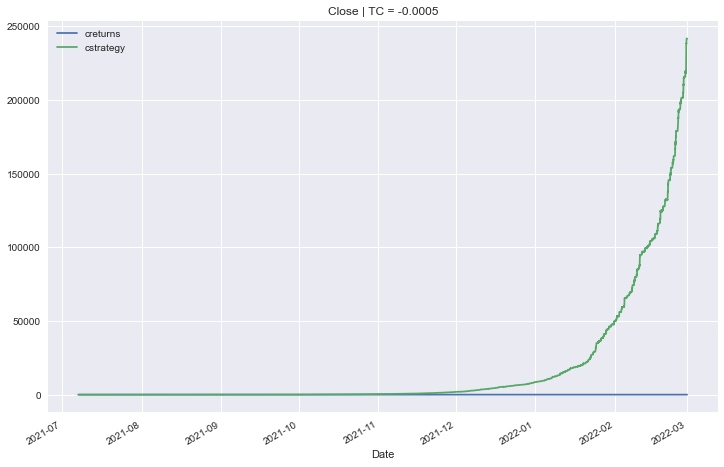

In [194]:
tester.plot_results()

In [195]:
tester.results.describe()

,Open Time,Open,High,Low,Close,Volume,Clos Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,...,vol,proba,position,hour,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net
count,22700.00000,22700.00000,22700.00000,22700.00000,22700.00000,22700.00000,22700.00000,22700.00000,22700.00000,22700.00000,...,22700.00000,22700.00000,22700.00000,22700.00000,22700.00000,22700.00000,22700.00000,22699.00000,22699.00000,22699.00000
mean,1635874249876.65210,47289.04365,47410.36746,47167.23947,47289.38560,3694.39583,1635875149876.40820,167417724.90037,36662.50674,1841.52249,...,3694.39583,0.50801,0.01930,11.49797,0.00055,1.35720,17264.86474,0.20763,0.00065,153548.05277
std,5899759427.21064,8869.80844,8884.51358,8853.41319,8869.43718,3936.71032,5899759427.21064,172589587.17324,31893.47215,1975.28322,...,3936.71032,0.15075,0.67491,6.91748,0.00242,0.25455,40276.77579,0.59273,0.00253,395040.41975
min,1625656500000.00000,29404.66000,29508.26000,29242.24000,29404.76000,353.88900,1625657399999.00000,16122267.03854,6656.00000,167.44600,...,353.88900,-0.14606,-1.00000,0.00000,-0.01977,0.84392,0.99937,0.00000,-0.01977,0.99871
25%,1630765575000.00000,41595.81750,41700.00000,41500.00000,41595.98500,1588.92450,1630766474999.00000,75980840.92601,19445.75000,777.12425,...,1588.92450,0.41793,0.00000,6.00000,0.00000,1.19380,18.56002,0.00000,0.00000,32.22179
50%,1635874650000.00000,46733.94500,46850.50000,46609.02000,46733.94500,2516.55550,1635875549999.00000,115754218.63787,27304.50000,1247.13500,...,2516.55550,0.50621,0.00000,11.00000,0.00000,1.34126,449.93204,0.00000,0.00000,1468.41049
75%,1640982825000.00000,52006.98000,52225.60250,51869.89000,52004.02500,4263.31100,1640983724999.00000,192888857.36125,41887.50000,2127.78675,...,4263.31100,0.59099,0.00000,17.00000,0.00058,1.49251,8555.43516,0.00000,0.00072,50572.40290
max,1646091900000.00000,68806.62000,69198.70000,68541.25000,68805.50000,98143.06100,1646092799999.00000,3789528483.40615,970423.00000,52258.58600,...,98143.06100,1.14647,1.00000,23.00000,0.05228,1.97472,241626.84304,2.00000,0.05228,2548432.70272


In [196]:
tester.results.loc[tester.results.cstrategy_net>3]

,Open Time,Open,High,Low,Close,Volume,Clos Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,...,proba,position,NYTime,hour,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-28 08:30:00+00:00,1627461000000,39691.51000,39691.59000,39350.00000,39390.70000,6314.17200,1627461899999,249556049.20453,68827,2767.17300,...,0.16964,-1.00000,2021-07-28 04:30:00-04:00,4,0.00761,1.13051,2.49385,0.00000,0.00761,3.00467
2021-07-28 09:45:00+00:00,1627465500000,39730.11000,39950.00000,39700.00000,39933.54000,4157.47700,1627466399999,165558228.78675,43363,2496.98300,...,0.69355,1.00000,2021-07-28 05:45:00-04:00,5,0.00511,1.14609,2.48897,0.00000,0.00511,3.00179
2021-07-28 10:00:00+00:00,1627466400000,39933.55000,40227.84000,39784.87000,40176.59000,11736.90600,1627467299999,469938122.30907,103449,7173.85600,...,0.80019,1.00000,2021-07-28 06:00:00-04:00,6,0.00607,1.15307,2.50412,0.00000,0.00607,3.02006
2021-07-28 10:15:00+00:00,1627467300000,40178.34000,40276.40000,40019.96000,40110.00000,9120.79900,1627468199999,366143794.64214,90820,4207.17300,...,0.80085,1.00000,2021-07-28 06:15:00-04:00,6,-0.00166,1.15116,2.49997,0.00000,-0.00166,3.01506
2021-07-28 10:30:00+00:00,1627468200000,40110.00000,40148.58000,39959.75000,40123.75000,5697.73800,1627469099999,228253059.71574,58398,2924.06700,...,0.67171,1.00000,2021-07-28 06:30:00-04:00,6,0.00034,1.15155,2.50083,0.00000,0.00034,3.01609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28 22:45:00+00:00,1646088300000,43660.20000,43911.80000,42788.00000,43020.60000,17359.65200,1646089199999,754489376.45548,162077,8012.42000,...,1.03400,0.00000,2022-02-28 17:45:00-05:00,17,-0.00000,1.23469,241626.84304,0.00000,0.00000,2548432.70272
2022-02-28 23:00:00+00:00,1646089200000,43029.90000,43322.00000,42968.40000,43252.00000,10888.74100,1646090099999,469913722.47830,97475,5689.86300,...,1.05272,0.00000,2022-02-28 18:00:00-05:00,18,0.00000,1.24133,241626.84304,0.00000,0.00000,2548432.70272
2022-02-28 23:15:00+00:00,1646090100000,43252.10000,43338.30000,42842.80000,43093.20000,9024.34200,1646090999999,388293177.92349,91043,4761.10200,...,0.18687,0.00000,2022-02-28 18:15:00-05:00,18,-0.00000,1.23677,241626.84304,0.00000,0.00000,2548432.70272


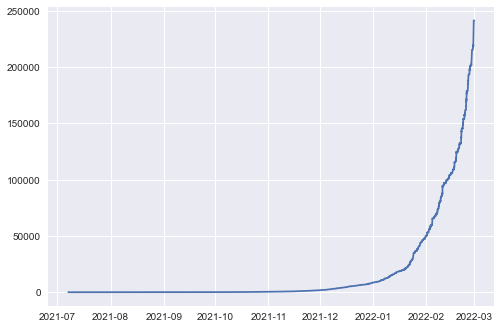

In [197]:
plt.plot(tester.results["NYTime"], tester.results["cstrategy"])
plt.show()

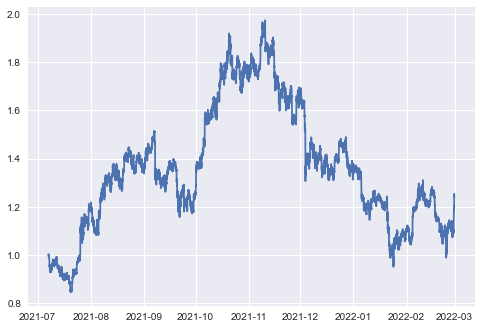

In [200]:
plt.plot(tester.results["NYTime"], tester.results["creturns"])
plt.show()

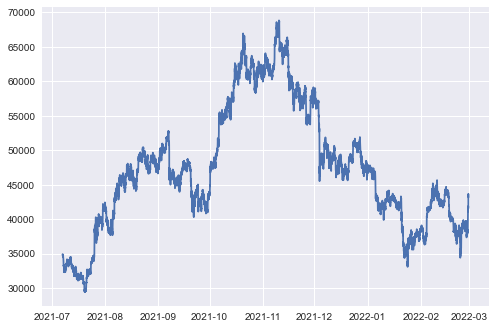

In [201]:
plt.plot(tester.results["NYTime"], tester.results["Close"])
plt.show()

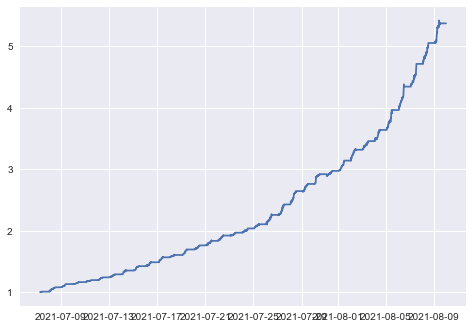

In [207]:
plt.plot(tester.results["NYTime"].loc[tester.results.NYTime<'2021-08-10'], tester.results["cstrategy"].loc[tester.results.NYTime<'2021-08-10'])
plt.show()

In [ ]:
tester.results.loc[tester.results.cstrategy_net>3]